In [1]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data as mnist_data
mnist = mnist_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


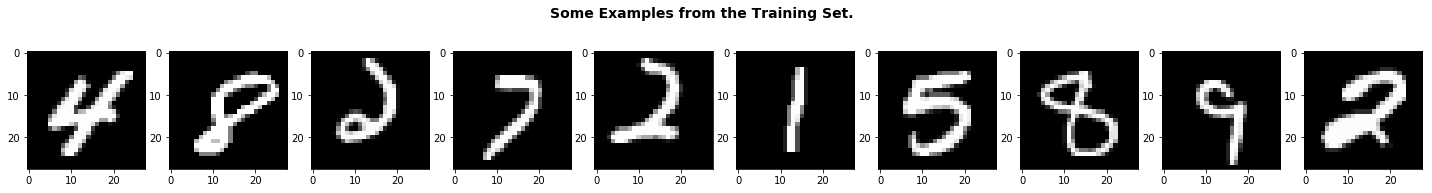

In [2]:
from matplotlib import pyplot as plt
import numpy as np

plt.ioff()
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Helper plotting routine.
def display_images(gens, title=""):
    fig, axs = plt.subplots(1, 10, figsize=(25, 3))
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    for i in xrange(10):
        reshaped_img = (gens[i].reshape(28, 28) * 255).astype(np.uint8)
        axs.flat[i].imshow(reshaped_img)
        #axs.flat[i].axis('off')        
    return fig, axs


batch_xs, batch_ys = mnist.train.next_batch(10)
list_of_images = np.split(batch_xs, 10)
_ = display_images(list_of_images, "Some Examples from the Training Set.")
plt.show()


In [3]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])  # A placeholder for the input images
W = tf.Variable(tf.zeros([784, 10]))  # The weights of the linear layer 
b = tf.Variable(tf.zeros([10]))   # The bias of the linear layer

init = tf.global_variables_initializer()   # Create an op that initializes these parameters

# model
Y=tf.nn.softmax(tf.matmul(X, W) + b)   # Compute the predictions of the model

# placeholder for correct answers
Y_ = tf.placeholder(tf.float32, [None, 10])  # Create a placeholder to hold the true labels

# loss function
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y))  # Define the loss

# % of correct answers found in batch
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))   # Is the model's prediction correct?
accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))   # Compute the average accuracy

optimizer = tf.train.GradientDescentOptimizer(0.003)   # Create the optimizer
train_step = optimizer.minimize(cross_entropy)   # Create an op that minimises the loss

sess = tf.Session()    # Create a session
sess.run(init)     # Initialize the variables

avg_train_cost = 0. 
avg_train_accuracy = 0.
avg_test_cost = 0.
avg_test_accuracy = 0.

num_steps = 5000   # How many training steps do we want?

for i in range(num_steps):
    # load batch of images and correct answers
    batch_X, batch_Y = mnist.train.next_batch(20)    # Get a batch of 20 MNIST images and labels
    train_data={X: batch_X, Y_: batch_Y}

    # train
    sess.run(train_step, feed_dict=train_data)   # Run the training step

    a,c = sess.run([accuracy, cross_entropy], feed_dict=train_data)   # Get the accuracy and cost
    
    if i % 100 == 0:
        print "Step", i, "Current train cost and accuracy: ", c, a
    
    avg_train_cost += c
    avg_train_accuracy += a
    
print("Completed Training")

avg_train_cost /= num_steps
avg_train_accuracy /= num_steps

print("Average train cost: ", avg_train_cost)
print("Average train accuracy: ", avg_train_accuracy)


# How well did we do on the test data? 
test_data={X:mnist.test.images, Y_:mnist.test.labels}
a,c = sess.run([accuracy, cross_entropy], feed_dict=test_data)

print("Test cost: ", c)
print("Test accuracy: ", a)


Step 0 Current train cost and accuracy:  0.230138 0.45
Step 100 Current train cost and accuracy:  0.226261 0.55
Step 200 Current train cost and accuracy:  0.223619 0.75
Step 300 Current train cost and accuracy:  0.21876 0.85
Step 400 Current train cost and accuracy:  0.219502 0.55
Step 500 Current train cost and accuracy:  0.214932 0.75
Step 600 Current train cost and accuracy:  0.21139 0.8
Step 700 Current train cost and accuracy:  0.206449 0.8
Step 800 Current train cost and accuracy:  0.209066 0.6
Step 900 Current train cost and accuracy:  0.204195 0.8
Step 1000 Current train cost and accuracy:  0.201159 0.75
Step 1100 Current train cost and accuracy:  0.203107 0.7
Step 1200 Current train cost and accuracy:  0.196832 0.6
Step 1300 Current train cost and accuracy:  0.199181 0.75
Step 1400 Current train cost and accuracy:  0.197522 0.65
Step 1500 Current train cost and accuracy:  0.187442 0.75
Step 1600 Current train cost and accuracy:  0.197548 0.55
Step 1700 Current train cost and a

In [4]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])   # A placeholder for the input image
X_reshaped = tf.reshape(X, [-1, 28, 28, 1])   # TensorFlow's convolutional operation wants a "volume" 

layer_1_depth = 2   # How deep is layer 1?
layer_2_depth = 4   # How deep is layer 2? 
filter_size = 5     # What size of filters do we want?

# Create the parameters for layer 1
W1 = tf.Variable(tf.truncated_normal([filter_size, filter_size, 1, layer_1_depth] ,stddev=0.1))
B1 = tf.Variable(tf.ones([layer_1_depth])/10)

# Create the parameters for layer 2
W2 = tf.Variable(tf.truncated_normal([filter_size, filter_size, layer_1_depth, layer_2_depth] ,stddev=0.1))
B2 = tf.Variable(tf.ones([layer_2_depth])/10)

# CONVOLUTIONAL LAYER 1: 
Y1 = tf.nn.relu(tf.nn.conv2d(X_reshaped, W1, strides=[1, 1, 1, 1], padding='SAME') + B1)

# POOLING 
pool = tf.nn.max_pool(Y1, ksize=[1, 2, 2, 1],
                      strides=[1, 2, 2, 1], 
                      padding='SAME')

# CONVOLUTIONAL LAYER 2
Y2 = tf.nn.relu(tf.nn.conv2d(pool, W2, strides=[1, 2, 2, 1], padding='SAME') + B2)

print "Shape of Y2: ", Y2.get_shape()

fully_connected_size = 100

# Create the parameters for the hidden fully connected layer
W3 = tf.Variable(tf.truncated_normal([7*7*layer_2_depth, fully_connected_size] ,stddev=0.1))
B3 = tf.Variable(tf.ones([fully_connected_size])/10)

# HIDDEN FULLY CONNECTED LAYER:
YY = tf.contrib.layers.flatten(Y2)  # First we need to flatten the volume
Y3 = tf.nn.relu(tf.matmul(YY, W3) + B3)  # Now compute the hidden output

print "Shape of Y3: ", Y3.get_shape()

# Create the parameters of the final logits layer
W4 = tf.Variable(tf.zeros([fully_connected_size, 10]))  
B4 = tf.Variable(tf.zeros([10]))

# Compute the model predictions! 
logits = tf.matmul(Y3, W4) + B4   # Compute the logits
Y = tf.nn.softmax(logits)     # Compute the model predictions

# placeholder for correct answers
Y_ = tf.placeholder(tf.float32, [None, 10])   

# loss function
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y))

# % of correct answers found in batch
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))

optimizer = tf.train.AdamOptimizer(0.003)   # Now we try an Adam optimizer
train_step = optimizer.minimize(cross_entropy)   # An op to minimise the cross entropy loss

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

avg_train_cost = 0.
avg_train_accuracy = 0.
avg_test_cost = 0.
avg_test_accuracy = 0.

num_steps = 5000

for i in range(num_steps):
    # load batch of images and correct answers
    batch_X, batch_Y = mnist.train.next_batch(20)
    train_data={X: batch_X, Y_: batch_Y}

    # train
    sess.run(train_step, feed_dict=train_data)

    # success ? add code to print it
    a,c = sess.run([accuracy, cross_entropy], feed_dict=train_data)
    
    if i % 100 == 0:
        print "Step", i, "Current train cost and accuracy: ", c, a
    
    avg_train_cost += c
    avg_train_accuracy += a
    
print("Completed Training")

avg_train_cost /= num_steps
avg_train_accuracy /= num_steps

print("Average train cost: ", avg_train_cost)
print("Average train accuracy: ", avg_train_accuracy)


# success on test data ?
test_data={X:mnist.test.images, Y_:mnist.test.labels}
a,c = sess.run([accuracy, cross_entropy], feed_dict=test_data)

print("Test cost: ", c)
print("Test accuracy: ", a)


Shape of Y2:  (?, 7, 7, 4)
Shape of Y3:  (?, 100)
Step 0 Current train cost and accuracy:  0.227722 0.3
Step 100 Current train cost and accuracy:  0.0679895 0.85
Step 200 Current train cost and accuracy:  0.0356579 0.9
Step 300 Current train cost and accuracy:  0.0394868 0.9
Step 400 Current train cost and accuracy:  0.0317542 0.95
Step 500 Current train cost and accuracy:  0.0239666 0.95
Step 600 Current train cost and accuracy:  0.00910121 1.0
Step 700 Current train cost and accuracy:  0.0575398 0.85
Step 800 Current train cost and accuracy:  0.00515653 1.0
Step 900 Current train cost and accuracy:  0.00470956 1.0
Step 1000 Current train cost and accuracy:  0.0217068 0.9
Step 1100 Current train cost and accuracy:  0.011616 0.95
Step 1200 Current train cost and accuracy:  0.00175393 1.0
Step 1300 Current train cost and accuracy:  0.00702303 0.95
Step 1400 Current train cost and accuracy:  0.013462 0.95
Step 1500 Current train cost and accuracy:  0.00506183 1.0
Step 1600 Current train 